#**Data Cleaning**


Pandas Pipeline
1.   Impor the data.
2.   Set the data types. (as function)
3.   Remove the outlier. (as function)





```
df.pipe(set_type).pipe(remove_out, min_row_country=10)
```



In [107]:
# Import libraries
import pandas as pd
import numpy as np


# This code is made to load our data stored on Google Drive
def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"

csv_names = ['products', 'orders', 'orderlines', 'brands']

# Google Drive file ids


files_id = {
    'products':"1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU",
    'orders':"1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ",
    'orderlines':"1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG",
    'brands':"1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD" 
} 

# Read data from Google Drive
products = pd.read_csv(gd_path(files_id['products']), sep=",")
orders = pd.read_csv(gd_path(files_id['orders']), sep=",")
orderlines = pd.read_csv(gd_path(files_id['orderlines']), sep=",")
brands = pd.read_csv(gd_path(files_id['brands']), sep=",")

In [108]:
# Display options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Functions

In [109]:
def start_pipeline(dataf):
    return dataf.copy()

def remove_dup(dataf):
    return dataf.drop_duplicates()

def check(df, operator, column_name, length_of_element):
  # Check if the operator is 'len' to indicate length check, otherwise assume dot count check
    if operator == len:  
        i = '.'  # Use '.' for length check
    else: 
        i = '\.'  # Use '\.' for dot count check
    return df[column_name].str.count(i).eq(length_of_element).sum()

def transform(df, column, new_column):    
  # Create a new column 'new_column' in the DataFrame 'df' to store the transformed values
    df[new_column] = (
    df[column].loc[df[column].notna() &
   (df[column].str.match(r'^\d{1,4}\.\d{1,3}$') | 
    df[column].str.match(r'^\d{1,5}$'))]
                .astype(float) # Convert the matched values to float data type
    .combine_first(df[column].loc[df[column].notna() &
                   df[column].str.match(r'^\d{3}\.\d{3}$')]
                             .astype(float) / 10) # Divide the matched values by 10
    .combine_first(df[column].loc[df[column].notna() &
                   df[column].str.match(r'^\d{1,3}\.\d{3}\.\d{3}$')]
                             .str.replace(".", "", regex=False) # Remove the dots from the matched values
                             .astype(float) / 100000) # Divide the matched values by 100000
)
    return df

def transform_OL(df, column, new_column):    # After analyzing the unti_price ORDERLINES, some new patterns were applied 
    df[new_column] = (
    df[column].loc[df[column].notna() &
   (df[column].str.match(r'^\d{1,4}\.\d{2}$'))]
              .astype(float)
    .combine_first(df[column].loc[df[column].notna() &
                   df[column].str.match(r'^\d{1,3}\.\d{3}\.\d{2}$')]
                             .str.replace(".", "", regex=False)
                             .astype(float)/100)
)
    return df


def analyze_prices(products_df, price_column):
  # Count and print the distribution of prices matching the pattern \d{1,3}\.\d{3}\.\d{3}
    case1_counts = (products_df[price_column].notna() & 
                    products_df[price_column].str.match(r'^\d{1,3}\.\d{3}\.\d{3}$')).value_counts(normalize=True)
    print("CASE 1: \d{1,3}\.\d{3}\.\d{3}")
    print(case1_counts)

    case2_counts = (products_df[price_column].notna() & 
                    products_df[price_column].str.match(r'^\d{3}\.\d{3}$')).value_counts(normalize=True)
    print("CASE 2: \d{3}\.\d{3}")
    print(case2_counts)

    case3_counts = (products_df[price_column].notna() & 
                    products_df[price_column].str.match(r'^\d{1,4}\.\d{1,3}$')).value_counts(normalize=True)
    print("CASE 3: \d{1,4}\.\d{1,3}")
    print(case3_counts)

    case4_counts = (products_df[price_column].notna() & 
                    products_df[price_column].str.match(r'^\d{1,5}$')).value_counts(normalize=True)
    print("CASE 4: \d{1,5}")
    print(case4_counts)
 
  # Count and print the distribution of missing (NA) prices
    na_counts = products_df[price_column].isna().value_counts(normalize=True)
    print("CASE Na")
    print(na_counts)


# 1 Products [non ok]

**products.csv**
* `sku` – stock keeping unit: a unique identifier for each product
* `name` – product name
* `desc` – product description
* `in_stock` – whether or not the product was in stock at the moment of the data extraction
* `type` – a numerical code for product type

In [110]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          19326 non-null  object
 1   name         19326 non-null  object
 2   desc         19319 non-null  object
 3   price        19280 non-null  object
 4   promo_price  19326 non-null  object
 5   in_stock     19326 non-null  int64 
 6   type         19276 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


### Preprocessing 
Check the size and drop duplicates.

In [111]:
products.nunique(), products.shape

(sku            10579
 name           10373
 desc            7098
 price           2690
 promo_price     4614
 in_stock           2
 type             126
 dtype: int64,
 (19326, 7))

In [112]:
products_1sp = products.pipe(start_pipeline).pipe(remove_dup)

#### **`price` analyses**

In [113]:
pd.set_option('display.max_colwidth', None) # Display full cell wight 

In [114]:
products_1sp[["name","price","promo_price"]].sample(5)

,name,price,promo_price
594,IK Multimedia iKlip microphone black iPad 2 Adapter,48.79,349.896
16910,Candy Apple Brown Pencil Case,35,350.005
1198,D-Link DGS-1100-16 Gigabit Smart Switch 16 ports,123.99,1.099.902
18781,"Open - Apple MacBook Pro Retina 15 ""i7 25 Ghz | RAM 16GB | 512GB Flash",2609,23.227.444
11910,MIXIT Belkin USB wall charger 24A Metallic Silver,19.99,179.903


In [115]:
products_1sp[products_1sp.price == products_1sp.promo_price].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 60 to 19306
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          204 non-null    object
 1   name         204 non-null    object
 2   desc         203 non-null    object
 3   price        204 non-null    object
 4   promo_price  204 non-null    object
 5   in_stock     204 non-null    int64 
 6   type         200 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.8+ KB


In [116]:
products_1sp[products_1sp.price.str.count('.') != products_1sp.promo_price.str.count('.')].sample(5)

,sku,name,desc,price,promo_price,in_stock,type
13135,APP1628,"Smart Apple iPad Keyboard Case with Keyboard Pro 9.7 """,Cover with keyboard shortcuts and Spanish (direct connection) for iPad Pro 97,169,1.580.006,0,5403
11032,PAC1391,Pack QNAP TS-451 + | 2GB RAM + 32TB Seagate IronWolf,Pack QNAP TS-451 + with 2GB of RAM memory + 32TB (4x8TB) NAS IronWolf Seagate Hard Drive for Mac and PC.,1918.95,13.543.675,1,12175397
19097,SXA0026-A,Open - SecurityXtra One adjustable desk Security Support iPad Black Pro,Reconditioned support desk with adjustable fastenings iPad Pro,210,1.436.844,0,1216
12639,SPE0176,"Speck SeeThru Case Macbook Pro Retina 15 ""Blue Calypso",Protective Case for MacBook Pro 15-inch Retina,49.9,369.897,0,13835403
10981,JMO0082,Just Mobile Tenc Case iPhone 6 / 6S Plus Crystal Clear,Polycarbonate shell with self-Heald for iPhone 6 / 6S Plus.,29.99,199.892,0,11865403


In [117]:
# Investigate the cases
(
#CASE 1
    (products_1sp.price.notna() & 
     products_1sp.price.str.match(r'^\d{1,3}\.\d{3}\.\d{3}$'))
     .value_counts(normalize=True)
#CASE 2
   ,(products_1sp.price.notna() & 
      products_1sp.price.str.match(r'^\d{3}\.\d{3}$'))
     .value_counts(normalize=True)
#CASE 3
   ,(products_1sp.price.notna() & 
      products_1sp.price.str.match(r'^\d{1,4}\.\d{1,3}$'))  
     .value_counts(normalize=True)
#CASE 4
   ,(products_1sp.price.notna() & 
      products_1sp.price.str.match(r'^\d{1,5}$'))  
     .value_counts(normalize=True)
#Na
   ,products_1sp.price.isna().value_counts(normalize=True)
)

# code too function

(False   0.96
 True    0.04
 Name: price, dtype: float64,
 False   0.99
 True    0.01
 Name: price, dtype: float64,
 True    0.66
 False   0.34
 Name: price, dtype: float64,
 False   0.70
 True    0.30
 Name: price, dtype: float64,
 False   1.00
 True    0.00
 Name: price, dtype: float64)

In [118]:
analyze_prices(products_1sp, "price")

CASE 1: \d{1,3}\.\d{3}\.\d{3}
False   0.96
True    0.04
Name: price, dtype: float64
CASE 2: \d{3}\.\d{3}
False   0.99
True    0.01
Name: price, dtype: float64
CASE 3: \d{1,4}\.\d{1,3}
True    0.66
False   0.34
Name: price, dtype: float64
CASE 4: \d{1,5}
False   0.70
True    0.30
Name: price, dtype: float64
CASE Na
False   1.00
True    0.00
Name: price, dtype: float64


#### **Clean by cases**

The columns `price` and `prome_price` seem to have multiple mistakes. 

* The range of "." count is 0-2.
* The range of digits in a nummer 1-11.

```
CASE 1
- 352.559.394 (10)   >  remove "." , float / 10000
-  12.808.289 (138)  >  remove "." , float / 10000
-   6.999.003 (229)  >  remove "." , float / 10000
	
r'^\d{1,3}\.\d{3}\.\d{3}$'

CASE 2	
-     164.923 (139) > float / 10 

r'^\d{3}\.\d{3}$'

CASE 3
-      91.989 (23)  > float
-       9.082 (3)   > float

-     679.99 > float
-      79.99 > float
-       9.99 > float
 
-    2117.5 (35) > float
-     119.9 (113)> float 
-      19.9 (347)> float
-       9.9 (11) > float 
       sum: 6941

r'^\d{1,4}\.\d{1,3}$'

CASE 4
- 11019 (42)   > float
-  2859 (1132) > float
-   209 (1112) > float
-    35        > float
-     9        > float 
     sum:3215

r'^\d{1,5}$'

```


##### CASE 4 and CASE 3

In [119]:
(
    products_1sp.loc[products_1sp.price.notna() &
                     (products_1sp.price.str.match(r'^\d{1,4}\.\d{1,3}$') | 
                      products_1sp.price.str.match(r'^\d{1,5}$'))]["price"]
                                        .astype(float)
    .combine_first(products_1sp.loc[products_1sp.price.notna() &
                                    products_1sp.price.str.match(r'^\d{3}\.\d{3}$')]["price"]
                                                          .astype(float) / 10)
)

0       59.99
1       59.00
2       59.00
3       25.00
4       34.99
         ... 
19321   29.99
19322   69.95
19323   69.95
19324   69.95
19325   69.95
Name: price, Length: 10156, dtype: float64

##### CASE 2

In [120]:
(
products_1sp[products_1sp.price.notna() &
             products_1sp.price.str.match(r'^\d{3}\.\d{3}$')].price.sample(10)
                                                              .astype(float)/10
)

12747   89.99
14945   34.99
15377   59.99
15344   59.99
19162   59.99
15502   79.99
15486   39.99
12127   49.99
18939   11.00
15328   59.99
Name: price, dtype: float64

##### CASE 1

In [121]:
(
products_1sp[products_1sp.price.notna() &
             products_1sp.price.str.match(r'^\d{1,3}\.\d{3}\.\d{3}$')]
                         .price.str.replace(".","", regex=False)
                         .astype(float)/100000
).copy()   

(
products_1sp.isna().sum()
,products_1sp[["desc","price","type"]].isna().value_counts(normalize=True)
)

(sku             0
 name            0
 desc            7
 price          46
 promo_price     0
 in_stock        0
 type           50
 dtype: int64,
 desc   price  type 
 False  False  False   0.99
               True    0.00
        True   False   0.00
 True   False  False   0.00
 dtype: float64)

##### Apply all Cases

In [122]:
products_1sp["cl_price"] = (
products_1sp[products_1sp.price.notna() &
             products_1sp.price.str.match(r'^\d{1,4}\.\d{1,3}$')| 
             products_1sp.price.str.match(r'^\d{1,5}$')]
                         .price.astype(float)
.combine_first(products_1sp[products_1sp.price.notna() &
               products_1sp.price.str.match(r'^\d{3}\.\d{3}$')]
                           .price.astype(float)/10)
.combine_first(products_1sp[products_1sp.price.notna() &
             products_1sp.price.str.match(r'^\d{1,3}\.\d{3}\.\d{3}$')]
                         .price.str.replace(".","", regex=False)
                         .astype(float)/100000)
)
# As functions 

(count   10476.00
 mean      646.07
 std      1336.52
 min         2.99
 25%        44.95
 50%       109.99
 75%       601.32
 max     15339.00
 Name: cl_price, dtype: float64,
 <Axes: >)

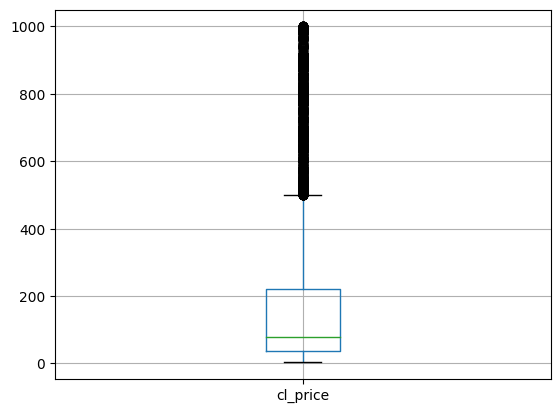

In [123]:
products_2sp = transform(products_1sp,'price','cl_price').dropna().copy()

(
products_2sp.cl_price.describe()
,products_2sp[products_2sp.cl_price < 1000].boxplot('cl_price')
)

####`promo_price`

In [124]:
products_2sp.promo_price

0        499.899
1        589.996
2        569.898
3        229.997
4          31.99
          ...   
19321    269.903
19322    649.903
19323    649.903
19324    649.903
19325    649.903
Name: promo_price, Length: 10476, dtype: object

In [125]:
# Investigate the cases
analyze_prices(products_1sp, "promo_price")

CASE 1: \d{1,3}\.\d{3}\.\d{3}
False   0.57
True    0.43
Name: promo_price, dtype: float64
CASE 2: \d{3}\.\d{3}
False   0.56
True    0.44
Name: promo_price, dtype: float64
CASE 3: \d{1,4}\.\d{1,3}
True    0.55
False   0.45
Name: promo_price, dtype: float64
CASE 4: \d{1,5}
False   0.99
True    0.01
Name: promo_price, dtype: float64
CASE Na
False   1.00
Name: promo_price, dtype: float64


Compare `price` to `promo_price` - is seemingly corrupted.
* 43% with X.xxx.xxx  
* 44% with xxx.xxx 

(count   10476.00
 mean      255.55
 std       299.21
 min         2.31
 25%        49.89
 50%       169.90
 75%       369.90
 max      9841.99
 Name: cl_promo_price, dtype: float64,
 <Axes: >)

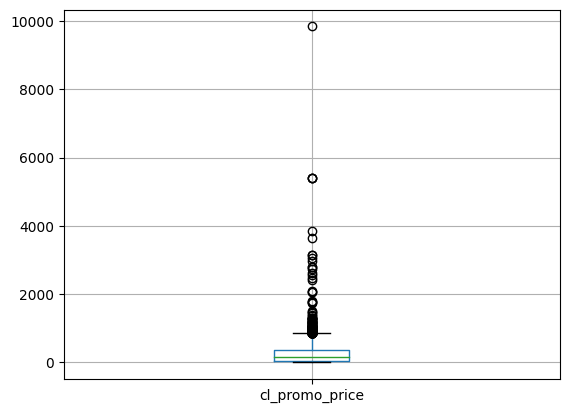

In [126]:
#Only testing the function
products_2sp = transform(products_1sp,'promo_price','cl_promo_price').dropna().copy()

(
products_2sp.cl_promo_price.describe()
,products_2sp[products_2sp.cl_promo_price > 1].boxplot('cl_promo_price')
)

####**`sku`**

In [127]:
products_2sp.sku

0        RAI0007
1        APP0023
2        APP0025
3        APP0072
4        KIN0007
          ...   
19321    BEL0376
19322    THU0060
19323    THU0061
19324    THU0062
19325    THU0063
Name: sku, Length: 10476, dtype: object

In [128]:
len(products_2sp.sku.unique())

10476

In [129]:
products_2sp[products_1sp.sku.str.slice(0,3) == "REP"].sort_values(by="desc").sample(2)

<ipython-input-129-0d7eca000b8f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  products_2sp[products_1sp.sku.str.slice(0,3) == "REP"].sort_values(by="desc").sample(2)


,sku,name,desc,price,promo_price,in_stock,type,cl_price,cl_promo_price
15389,REP0297,Full screen iPhone repair,Repair service including parts and labor for iPhone,59.99,59.99,0,"1,44E+11",59.99,59.99
19307,REP0418,iPhone charging connector repair,Repair service including parts and labor for iPhone,49.99,499.899,0,"1,44E+11",49.99,499.90


In [130]:
products_2sp["brands"] = products_2sp.sku.str.slice(0,3)

products_3sp = (
products_2sp.merge(
    brands,
    how="inner", 
    left_on="brands", 
    right_on="short")
[["sku","long", "name", "desc", "price", "promo_price","cl_price","cl_promo_price", "type",]]
.copy()
)

### Comparing, checking for differences

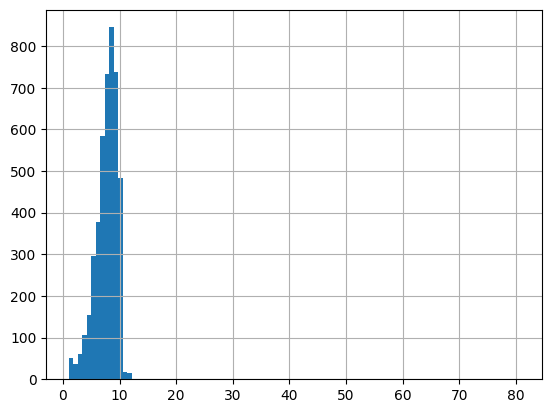

In [131]:
products_3sp['cl_deff'] = products_3sp.cl_price - products_3sp.cl_promo_price
products_3sp['cl_deff_2'] = products_3sp.cl_promo_price/products_3sp.cl_price
products_3sp[["price", "promo_price","cl_price","cl_promo_price","cl_deff","cl_deff_2"]]


products_3sp[products_3sp.cl_deff_2 > 1].cl_deff_2.hist(bins=100);

In [132]:
#Drop columns
#products_3sp = products_3sp.drop(["price","promo_price","cl_deff",'cl_deff_2'], axis=1)
products_3sp = products_3sp.drop(['cl_promo_price'], axis=1)
products_3sp.sample(5)

,sku,long,name,desc,price,promo_price,cl_price,type,cl_deff,cl_deff_2
7939,OLL0021,Olloclip,Olloclip 4-in-1 Lens iPhone 5 / 5s / SE Gold / White,Wide angle fisheye macro macro x10 and x15 for iPhone 5 / 5s / SE,69.99,599.906,69.99,11905404,-529.92,8.57
9278,THU0040,Thule,Thule Subterra mini iPad Sleeve Case Black,Case with outside pocket and zipper for iPad mini,39.95,31.99,39.95,12635403,7.96,0.80
1716,APP2375,Apple,"Apple Macbook Pro 13 ""Core i7 25GHz | 8GB | 256GB SSD Silver",New MacBook Pro 13-inch Core i7 25GHz with 8GB of RAM and 256GB PCIe SSD,2109,19.820.042,2109.00,"1,02E+12",1910.80,0.09
4850,PAC1403,Pack,Synology DS716 + II Pack | 2GB RAM | Seagate 6TB IronWolf,Synology DS716 + II with 2GB of RAM memory + 6TB (2x3TB) Seagate Hard Drive for Mac and PC IronWolf,751.88,6.871.796,751.88,12175397,683.16,0.09
9979,GLY0017,Glyph Atom,Glyph Blackbox Plus 1TB External Hard Drive USB-C (3.1),1TB external hard drive with USB-C connection 7200rpm HDD disk for Mac and PC,140.99,1.319.941,140.99,11935397,127.79,0.09


### Status
`promo_price` not OK

`type, name, desc, price`
keep, no cleaning required

Last Version: `products_3sp` 

# 2 Brands [ok]

**brands.csv**
* `short` – the 3-character code by which the brand can be identified in the first 3 characters of products.sku
* `long` – brand name

In [133]:
brands.sample(10)

,short,long
70,KEN,Jaybird
31,DRO,Drobo
166,TOS,Toshiba
111,NTE,NewerTech
146,SNA,Sena
123,PHI,Philips
178,WIK,Wikango
174,UAG,Urban Armor Gear
136,RET,Retrak Utopia
76,LAN,LandingZone


In [134]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   short   187 non-null    object
 1   long    187 non-null    object
dtypes: object(2)
memory usage: 3.0+ KB


### Status

All datatype are OK

Last Version: `brands` 

# 3 Orders [ok]


**orders.csv** – Every row in this file represents an order.
* `order_id` – a unique identifier for each order
* `created_date` – a timestamp for when the order was created
* `total_paid` – the total amount paid by the customer for this order, in euros
state 
 * “Shopping basket” – products have been placed in the shopping basket, but the order has not been processed yet.
 * “Pending” – the shopping basket has been processed, but payment confirmation is pending.
 * “Completed” – the order has been placed and paid, and the transaction is completed.
 * “Cancelled” – the order has been cancelled and the payment returned to the 
customer.

In [135]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


In [136]:
orders.sample(5)

,order_id,created_date,total_paid,state
183168,483575,2018-01-06 12:25:44,22.98,Completed
184216,484623,2018-01-07 22:26:37,1585.00,Shopping Basket
183835,484242,2018-01-07 13:11:27,22.99,Shopping Basket
193933,494416,2018-01-19 10:49:07,889.00,Shopping Basket
43585,343075,2017-04-04 12:05:18,142.99,Shopping Basket


In [137]:
orders.nunique()

order_id        226909
created_date    224828
total_paid       31236
state                5
dtype: int64

In [138]:
len(orders.order_id.unique())

226909

All `order_is` are unique.

In [139]:
orders_1sp = orders.copy()
orders_1sp["created_date"] = pd.to_datetime(orders.created_date)

In [140]:
orders_1sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      226909 non-null  int64         
 1   created_date  226909 non-null  datetime64[ns]
 2   total_paid    226904 non-null  float64       
 3   state         226909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.9+ MB


In [141]:
orders_2sp_comp = orders_1sp[orders_1sp.state == "Completed"].dropna().copy()

In [142]:
orders_2sp_comp

,order_id,created_date,total_paid,state
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
5,245275,2017-06-28 11:35:37,149.00,Completed
6,245595,2017-01-21 12:52:47,112.97,Completed
...,...,...,...,...
226549,527042,2018-03-14 11:47:50,18.98,Completed
226577,527070,2018-03-14 11:50:48,24.97,Completed
226581,527074,2018-03-14 11:51:42,24.97,Completed
226603,527096,2018-03-14 11:58:40,34.96,Completed


### Status
All datatype are OK.
Price range is not OK

Last Version: `orders_2sp_comp` 

#4 Orderlines [non ok]

**orderlines.csv** – Every row represents each one of the different products involved in an order.
* `id` – a unique identifier for each row in this file
* `id_order` – corresponds to orders.order_id
* `product_id` – an old identifier for each product, nowadays not in use
* `product_quantity` – how many units of that product were purchased on that order
* `sku` – stock keeping unit: a unique identifier for each product
* `unit_price` – the unitary price (in euros) of each product at the moment of placing that order
date 
* `timestamp` for the processing of that product

In [143]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                293983 non-null  int64 
 1   id_order          293983 non-null  int64 
 2   product_id        293983 non-null  int64 
 3   product_quantity  293983 non-null  int64 
 4   sku               293983 non-null  object
 5   unit_price        293983 non-null  object
 6   date              293983 non-null  object
dtypes: int64(4), object(3)
memory usage: 15.7+ MB


###`unti_price` analyses

In [144]:
analyze_prices(orderlines,'unit_price')

CASE 1: \d{1,3}\.\d{3}\.\d{3}
False   1.00
Name: unit_price, dtype: float64
CASE 2: \d{3}\.\d{3}
False   1.00
Name: unit_price, dtype: float64
CASE 3: \d{1,4}\.\d{1,3}
True    0.88
False   0.12
Name: unit_price, dtype: float64
CASE 4: \d{1,5}
False   1.00
Name: unit_price, dtype: float64
CASE Na
False   1.00
Name: unit_price, dtype: float64


In [145]:
orderlines.unit_price.str.match(r'^\d+\.\d+\.\d+$').value_counts(normalize=True)
orderlines.unit_price.str.count(".").value_counts(normalize=True)
((orderlines.unit_price.str.endswith("0")) | (orderlines.unit_price.str.endswith("9"))).value_counts(normalize=True)

True    0.87
False   0.13
Name: unit_price, dtype: float64

In [146]:
orderlines[orderlines.unit_price.str.match(r'^\d+\.\d+\.\d{2}$')].sample(5)
orderlines[orderlines.unit_price.str.match(r'^\d{3}\.\d{2}$')].sample(5)

,id,id_order,product_id,product_quantity,sku,unit_price,date
78646,1271423,367285,0,1,APP2131,989.00,2017-06-19 21:14:23
26640,1177842,322983,0,1,SYN0147,331.99,2017-02-12 17:11:32
5961,1135633,305065,0,4,WDT0141,112.99,2017-01-08 22:20:10
173456,1456637,447635,0,1,APP1776,109.99,2017-11-27 11:26:10
103579,1316373,388680,0,1,SAM0074,160.58,2017-08-11 12:57:35


In [147]:
orderlines[orderlines.unit_price.str.count(".") > 4].sample(5)

,id,id_order,product_id,product_quantity,sku,unit_price,date
140628,1395481,420915,0,1,APP1190,56.00,2017-11-02 08:12:06
125538,1368320,407772,0,1,LAC0226,232.94,2017-10-03 09:57:26
215911,1522224,475003,0,1,QNA0257,300.69,2017-12-28 15:13:33
164649,1442066,441400,0,1,BNQ0063,169.99,2017-11-24 20:19:54
204332,1500155,464596,0,1,APP2075,3.049.00,2017-12-16 23:00:22


In [148]:
orderlines_1sp = transform_OL(orderlines,"unit_price","cl_unit_price").copy()

In [149]:
orderlines[orderlines['id_order'] == 461458], orders_1sp[orders_1sp['order_id'] == 461458]

(             id  id_order  product_id  product_quantity      sku unit_price  \
 199773  1492821    461458           0                 1  MIN0011      13.99   
 
                        date  cl_unit_price  
 199773  2017-12-13 07:37:44          13.99  ,
         order_id        created_date  total_paid            state
 161200    461458 2017-12-13 07:37:44       13.99  Shopping Basket)

* `orders`:`created_date` is the same as `orderlines`:`date`
 
* `orders`:`order_id` is the same as `orderlines`:`id_order`






In [150]:
orderlines_2sp = orderlines_1sp.copy()
orderlines_2sp["date"] = pd.to_datetime(orderlines.date)
orderlines_2sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                293983 non-null  int64         
 1   id_order          293983 non-null  int64         
 2   product_id        293983 non-null  int64         
 3   product_quantity  293983 non-null  int64         
 4   sku               293983 non-null  object        
 5   unit_price        293983 non-null  object        
 6   date              293983 non-null  datetime64[ns]
 7   cl_unit_price     293982 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 17.9+ MB


In [151]:
orderlines_2sp[orderlines_2sp.product_quantity ==2]
orderlines_2sp["sum_price"] = orderlines_1sp.product_quantity * orderlines_1sp.cl_unit_price
orderlines_2sp

,id,id_order,product_id,product_quantity,sku,unit_price,date,cl_unit_price,sum_price
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19,18.99,18.99
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45,399.00,399.00
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57,474.05,474.05
3,1119112,299542,0,1,WDT0315,68.39,2017-01-01 00:51:40,68.39,68.39
4,1119113,299543,0,1,JBL0104,23.74,2017-01-01 01:06:38,23.74,23.74
...,...,...,...,...,...,...,...,...,...
293978,1650199,527398,0,1,JBL0122,42.99,2018-03-14 13:57:25,42.99,42.99
293979,1650200,527399,0,1,PAC0653,141.58,2018-03-14 13:57:34,141.58,141.58
293980,1650201,527400,0,2,APP0698,9.99,2018-03-14 13:57:41,9.99,19.98
293981,1650202,527388,0,1,BEZ0204,19.99,2018-03-14 13:58:01,19.99,19.99


In [152]:
#Drop columns
orderlines_2sp = orderlines_2sp.drop(['unit_price'], axis=1)
orderlines_2sp

,id,id_order,product_id,product_quantity,sku,date,cl_unit_price,sum_price
0,1119109,299539,0,1,OTT0133,2017-01-01 00:07:19,18.99,18.99
1,1119110,299540,0,1,LGE0043,2017-01-01 00:19:45,399.00,399.00
2,1119111,299541,0,1,PAR0071,2017-01-01 00:20:57,474.05,474.05
3,1119112,299542,0,1,WDT0315,2017-01-01 00:51:40,68.39,68.39
4,1119113,299543,0,1,JBL0104,2017-01-01 01:06:38,23.74,23.74
...,...,...,...,...,...,...,...,...
293978,1650199,527398,0,1,JBL0122,2018-03-14 13:57:25,42.99,42.99
293979,1650200,527399,0,1,PAC0653,2018-03-14 13:57:34,141.58,141.58
293980,1650201,527400,0,2,APP0698,2018-03-14 13:57:41,9.99,19.98
293981,1650202,527388,0,1,BEZ0204,2018-03-14 13:58:01,19.99,19.99


In [153]:
orderlines_2sp.id_order.nunique()

204855

Different ammount of unique `id_order`

`orders`: 226909
`orderlines`: 204855

In [154]:
orderlines_2sp.query('product_quantity == 1').id_order.nunique()

194780

In [155]:
orderlines_2sp.query('product_quantity != 1').id_order.nunique()

14734

REP is not in `orderlines`

In [156]:
orderlines_2sp.sku.isin(["REP"]).sum() 

0

### Status
All OK 

Last Version `orderlines_2sp`

# Combine Tables

The `products` table should be the primary reference for all the products being sold. It is likely that, during the Data Cleaning phase, you deleted many rows from `products`. Any order involving products not present there is susceptible to containing corrupted information.

You might choose to deal with this in many different ways, but a conservative one would be to delete all of the potentially corrupted rows. 

Exclude orders with unknown products.

`orderlines.sku` are in `produts.sku`. If `sku` not in `products` remove it from `orderlines.order_id` and from `orders`.  If no it will affect the Orders. 


### All clean Tables

In [157]:
orderlines_2sp.head(1).sort_values(by="id_order")

,id,id_order,product_id,product_quantity,sku,date,cl_unit_price,sum_price
0,1119109,299539,0,1,OTT0133,2017-01-01 00:07:19,18.99,18.99


In [158]:
products_3sp.sample(1)

,sku,long,name,desc,price,promo_price,cl_price,type,cl_deff,cl_deff_2
8736,PHI0073-A,Philips,Open - Philips Hue White and Color Light Bulb 10W A60 E27 Single,Independent bulb color and white for Philips Hue open box system,59.95,450.444,59.95,11905404,-390.49,7.51


In [159]:
orders_2sp_comp.sample(1)

,order_id,created_date,total_paid,state
175762,476151,2017-12-29 12:39:01,110.54,Completed


In [160]:
orderlines_in_prod = orderlines_2sp.merge(
    products_3sp,
    how = "left",
    left_on = 'sku',
    right_on = 'sku'
)

len(set(orderlines_in_prod.sku)), len(set(orderlines_2sp.sku))

(7951, 7951)

In [161]:
orderlines_in_prod.isna().sum() #NA from products

id                     0
id_order               0
product_id             0
product_quantity       0
sku                    0
date                   0
cl_unit_price          1
sum_price              1
long                2031
name                2031
desc                2031
price               2031
promo_price         2031
cl_price            2031
type                2031
cl_deff             2031
cl_deff_2           2031
dtype: int64

This `ska` and `id_order` are not in `produkts`.

In [162]:
orderlines_in_prod[orderlines_in_prod['type'].isna()].tail(5)

,id,id_order,product_id,product_quantity,sku,date,cl_unit_price,sum_price,long,name,desc,price,promo_price,cl_price,type,cl_deff,cl_deff_2
291957,1646559,525670,0,1,DOD0010,2018-03-11 22:54:41,21.99,21.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292161,1646897,523315,0,1,LUM0008,2018-03-12 11:07:33,59.99,59.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292194,1646975,525863,0,1,UBT0009,2018-03-12 12:03:31,159.95,159.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292356,1647280,526003,0,1,NET0028,2018-03-12 15:59:19,404.99,404.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293648,1649570,527099,0,2,CAL0010,2018-03-14 11:54:58,299.99,599.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
drop_ids = list(orderlines_in_prod[orderlines_in_prod['type'].isna()].id_order.drop_duplicates())

Remove no corresponding `id_orders` from `orderlines`

In [164]:
orderlines_3sp = orderlines_2sp.set_index("id_order").drop(drop_ids, axis=0).reset_index().copy()

In [165]:
orderlines_2sp.shape, orderlines_3sp.shape

((293983, 8), (289669, 8))

Remove no corresponding `order_id` from `orders`


In [166]:
# Convert drop_ids to a set for faster membership checking
drop_ids_set = set(drop_ids)

# Filter rows with existing index values
orders_3sp_comp = orders_2sp_comp.set_index("order_id").loc[lambda x: x.index.isin(drop_ids_set) == False].reset_index()
orders_3sp_comp

,order_id,created_date,total_paid,state
0,241423,2017-11-06 13:10:02,136.15,Completed
1,242832,2017-12-31 17:40:03,15.76,Completed
2,243330,2017-02-16 10:59:38,84.98,Completed
3,245275,2017-06-28 11:35:37,149.00,Completed
4,245595,2017-01-21 12:52:47,112.97,Completed
...,...,...,...,...
46157,527042,2018-03-14 11:47:50,18.98,Completed
46158,527070,2018-03-14 11:50:48,24.97,Completed
46159,527074,2018-03-14 11:51:42,24.97,Completed
46160,527096,2018-03-14 11:58:40,34.96,Completed


# Big table

In [167]:
all_commbine = (
orders_3sp_comp
 .merge(
    orderlines_1sp, 
    how = "inner", 
    left_on ="order_id", 
    right_on ="id_order")
 .merge(
    products_3sp, 
    how = "inner",
    left_on = "sku",
    right_on = "sku")
 .copy()
)

In [168]:
(
all_commbine[(all_commbine.product_quantity == 1)
           & (all_commbine.state == "Completed")
           & (all_commbine.total_paid > 100) 
           & (all_commbine.total_paid < 100000) ]
            [["total_paid", 
              "product_quantity",
              'cl_unit_price',
              'cl_price']]
              .sort_values(by="total_paid")
              .drop_duplicates()
)

,total_paid,product_quantity,cl_unit_price,cl_price
12773,100.15,1,80.16,107.98
55545,100.15,1,80.16,129.90
32364,100.19,1,95.20,124.99
35809,100.24,1,93.25,105.00
10239,100.26,1,17.99,29.99
...,...,...,...,...
31776,9987.76,1,429.00,429.00
19046,9987.76,1,63.20,79.00
41421,9987.76,1,1112.99,1159.00
47294,10586.97,1,2713.59,2849.00


# Save tables

In [169]:
from google.colab import files

orders_3sp_comp.to_csv("orders_cl.csv", index=False)
files.download("orders_cl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [170]:
orderlines_3sp.to_csv("orderslines_cl.csv", index=False)
files.download("orderslines_cl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [171]:
products_3sp.to_csv("products_cl.csv", index=False)
files.download("products_cl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>